In [127]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import os
import torch
from torch import nn

from tqdm import tqdm
import glob

import json
import yaml

from models.models_factories import segmentation_nns_factory_dict

import seaborn as sns

from train_nn import create_model

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from data import HSI_dataset, SegmentationDataset

from train_nn import create_model, create_seismic_sensors_dataset, create_hsi_uav_dataset

%matplotlib inline

# Визуализация кривых обучения

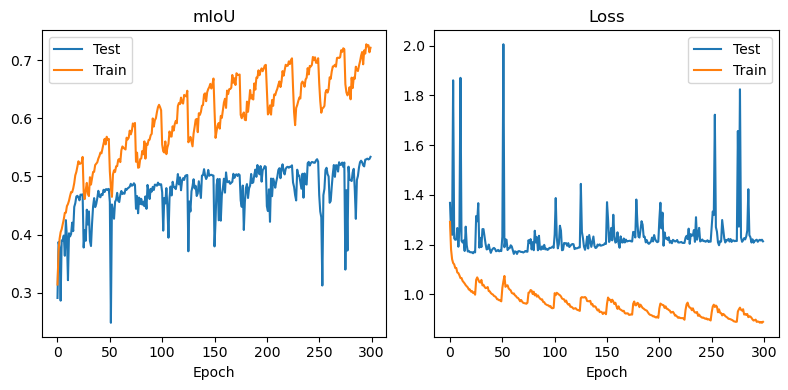

In [184]:
path_to_results_df = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\version_0\metrics.csv'
path_to_results_df = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-cspdarknet53_2025-10-08T01-25-06\unet_tu-cspdarknet53__b_10m_st_2\version_0\metrics.csv'
#path_to_results_df = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_efficientnet-b2_2025-10-09T12-31-41\unet_efficientnet-b2__b_10-20m_st_1 2025-10-09T12-31-45\version_0\metrics.csv'
df = pd.read_csv(path_to_results_df)

train_iou = df['train_iou_mean'].dropna().to_numpy()
val_iou = df['val_iou_mean'].dropna().to_numpy()
train_loss = df['train_loss'].dropna().to_numpy()
val_loss = df['val_loss'].dropna().to_numpy()
fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].plot(val_iou, label=f'Test', linewidth=1.5)
axs[0].plot(train_iou, label=f'Train', linewidth=1.5)
axs[0].set_title(f'mIoU')
axs[0].set_xlabel('Epoch')
axs[0].legend()



axs[1].plot(val_loss, label=f'Test', linewidth=1.5)
axs[1].plot(train_loss, label=f'Train', linewidth=1.5)
axs[1].set_title(f'Loss')
#axs[1].set_ylim([0.7, 3])
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# визуализация матрицы ошибок

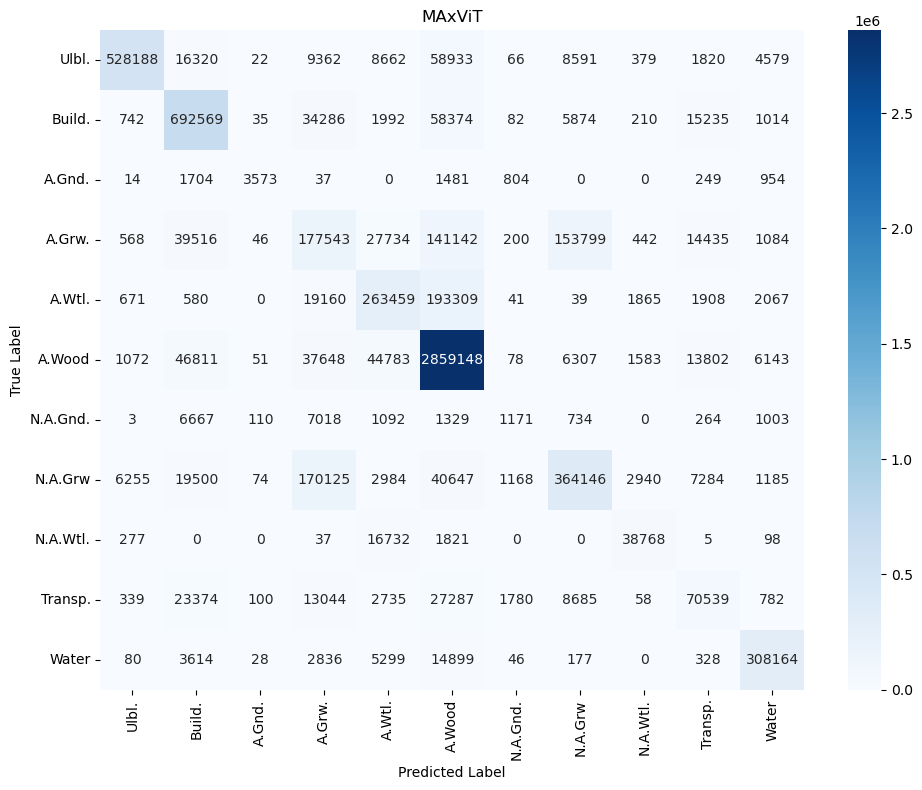

In [178]:
path_to_confusion = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\version_0\val_confusion_matrices.csv'
best_epoch = 172
model_name = 'MAxViT'

#path_to_confusion = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-cspdarknet53_2025-10-08T01-25-06\unet_tu-cspdarknet53__b_10m_st_2\version_0\val_confusion_matrices.csv'
#model_name = 'CSP'


#path_to_confusion = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_efficientnet-b2_2025-10-09T12-31-41\unet_efficientnet-b2__b_10-20m_st_1 2025-10-09T12-31-45\version_0\val_confusion_matrices.csv'
#model_name = 'EffNet'



classes = ['Ulbl.', 'Build.', 'A.Gnd.', 'A.Grw.', 'A.Wtl.', 'A.Wood', 'N.A.Gnd.', 'N.A.Grw', 'N.A.Wtl.', 'Transp.', 'Water', ]

df = pd.read_csv(path_to_confusion)
path_to_metrics = os.path.join(os.path.split(path_to_confusion)[0], 'metrics.csv')
metrix_df = pd.read_csv(path_to_metrics)
best_epoch = metrix_df['val_iou_mean'].dropna().argmax()
conf_df = df[df['epoch']==best_epoch].drop(columns=['epoch'])
conf_df['classes'] = classes

conf_matrix = conf_df.iloc[:, 1:].values



conf_df = conf_df.set_index('classes')
conf_df.columns = classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, 
            annot=True, 
            fmt='d',  # 'd' для целых чисел, 'f' для дробных
            cmap='Blues',
            xticklabels=True,
            yticklabels=True)

plt.title(model_name)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [136]:
conf_df

,classes,UNLABELED,buildings_territory,natural_ground,natural_grow,natural_wetland,natural_wood,quasi_natural_ground,quasi_natural_grow,quasi_natural_wetland,transport,water
1903,UNLABELED,528147,16097,18,9855,9463,58253,74,8105,310,1984,4616
1904,buildings_territory,660,704961,125,36598,611,45549,49,4510,548,15848,954
1905,natural_ground,15,1512,3705,39,0,1297,1032,0,0,229,987
1906,natural_grow,534,38544,184,188634,27274,145972,319,140109,1261,12864,814
1907,natural_wetland,425,690,0,14738,286155,175320,216,3,1562,2001,1989
1908,natural_wood,1062,53479,64,35798,76827,2826333,203,5034,1048,11477,6101
1909,quasi_natural_ground,0,4512,261,8710,1307,955,1420,582,5,587,1052
1910,quasi_natural_grow,6254,19211,152,190087,10437,34766,7334,338419,1260,7440,948
1911,quasi_natural_wetland,273,0,0,7,23506,180,0,0,33763,5,4
1912,transport,320,21497,313,13276,2302,26844,2569,7885,247,72820,650


# Seismic Sensors

In [3]:
class_name2idx_dict = {
    'Unlabeled': 0,
    'Buildings': 1,
    'Applicable Ground': 2,
    'Applicable Grow': 3,
    'Applicable Wetland': 4,
    'Applicable Wood': 5,
    'Non-Applicable Ground': 6,
    'Non-Applicable Grow': 7,
    'Non-Applicable Wetland': 8,
    'Transport': 9,
    'Water': 10
}

class_idx2name_dict = {v:k for k, v in class_name2idx_dict.items()}

class_idx2color_dict = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}



In [ ]:


# Предполагается, что у вас уже есть:
# mask: np.ndarray формы (96, 96) с int значениями
# pix2color: dict вида {int_value: "#RRGGBB"}
pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

mask = np.random.randint(0, 11, size=(96,96))


# 1) Проверим, что все значения в mask имеют цвет
vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Для значений {missing} нет цветов в pix2color")

# 2) Отсортированный список дискретных значений и соответствующие цвета
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# 3) Дискретная карта цветов и нормировка по «коробкам» вокруг целых
cmap = ListedColormap(colors, name="pixmap", N=len(colors))

# Границы по центрам между соседними целыми: [v0-0.5, v0+0.5, v1+0.5, ...]
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate(([boundaries[0] - 0.5], (boundaries[:-1] + boundaries[1:]) / 2, [boundaries[-1] + 0.5]))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# 4) Отрисовка
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
im = ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
ax.set_title("Mask colored by pix2color")
ax.set_xticks([])
ax.set_yticks([])

# 5) Дискретный colorbar с метками именно ваших значений
cbar = plt.colorbar(im, ax=ax, ticks=values, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Value", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()

In [ ]:
pix2class = {
    0: 'Unlabeled',
    1: 'Buildings',
    2: 'A. Ground',
    3: 'A. Low B.',
    4: 'A. Wetland',
    5: 'A. Wood',
    6: 'N.A. Ground',
    7: 'N.A. Low B.',
    8: 'N.A. Wetland',
    9: 'Transport',
    10: 'Water',
}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}
img = np.random.randint(0, 65536, size=(96,96,3))/65536
mask = np.random.randint(0, 11, size=(96,96))
gt_mask = np.random.randint(0, 11, size=(96,96))

vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Нет цветов для значений: {missing}")

# Сортируем значения
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# Создаём дискретную cmap и norm
cmap = ListedColormap(colors, name="pixmap", N=len(colors))
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate((
    [boundaries[0] - 0.5],
    (boundaries[:-1] + boundaries[1:]) / 2,
    [boundaries[-1] + 0.5]
))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Рисуем маску
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 9), dpi=120)
im = axs[0].imshow(img)
axs[0].set_title("Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[1].set_title("Ground truth")
axs[1].set_xticks([])
axs[1].set_yticks([])

im = axs[2].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[2].set_title("Pred")
axs[2].set_xticks([])
axs[2].set_yticks([])

# Формируем список патчей для легенды
patches = [
    mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
    for val in values if val in vals_in_mask
]

# Добавляем легенду сбоку
#axs[2].legend(handles=patches, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Classes")

plt.legend(ncol=len(pix2color), handles=patches, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Classes")
plt.tight_layout()
plt.show()

In [169]:
len(test_loader.dataset), len(train_loader.dataset)

(726, 1694)

In [ ]:
patches = [
    mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
    for val in values if val in vals_in_mask
]
plt.figure(figsize=(20, 20))
plt.legend(ncol=6, handles=patches, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Classes")
plt.show()

# Визуализация нескольких нейронных сетей

In [96]:
def draw_results_multiple_nns(pix2color, pix2class, img, gt_mask, pred_mask_dict, figsize, set_title, legend, transpose, path_to_result=None, transparent_bg=False):
    pred_masks_num = len(pred_mask_dict.keys())  
    
    all_mask_vals = np.unique(gt_mask).tolist()
    for pred_mask in pred_mask_dict.values():
        all_mask_vals += np.unique(pred_mask).tolist()

    missing = [v for v in all_mask_vals if v not in pix2color]
    if missing:
        raise ValueError(f"Нет цветов для значений: {missing}")
    
    values = sorted(pix2color.keys())
    colors = [pix2color[v] for v in values]

    # Создаём дискретную cmap и norm
    cmap = ListedColormap(colors, name="pixmap", N=len(colors))
    boundaries = np.array(values, dtype=float)
    boundaries = np.concatenate((
        [boundaries[0] - 0.5],
        (boundaries[:-1] + boundaries[1:]) / 2,
        [boundaries[-1] + 0.5]
    ))
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Рисуем маску
    if transpose:
        figsize = figsize[::-1]
        fig, axs = plt.subplots(nrows=2 + pred_masks_num, ncols=1, figsize=figsize, dpi=120)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2 + pred_masks_num, figsize=figsize, dpi=120)
    im = axs[0].imshow(img)
    if set_title:
        axs[0].set_title("Image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[1].set_title("Ground truth")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    for idx, (model_name, pred_mask) in enumerate(pred_mask_dict.items()):
        im = axs[idx+2].imshow(pred_mask, cmap=cmap, norm=norm, interpolation="nearest")
        if set_title:
            axs[idx+2].set_title(f"{model_name}")
        axs[idx+2].set_xticks([])
        axs[idx+2].set_yticks([])

    # Формируем список патчей для легенды
    patches = [
        mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
        for val in values if val in all_mask_vals
    ]
    if legend:
        # Добавляем легенду сбоку
        axs[-1].legend(
            handles=patches,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            title="Classes"
        )

    plt.tight_layout()
    if path_to_result is None:
        plt.show()
    else:
        plt.savefig(path_to_result, transparent=transparent_bg)

    plt.close()

In [171]:
pix2class = {
    0: 'Unlabeled',
    1: 'Buildings',
    2: 'A. Ground',
    3: 'A. Low B.',
    4: 'A. Wetland',
    5: 'A. Wood',
    6: 'N.A. Ground',
    7: 'N.A. Low B.',
    8: 'N.A. Wetland',
    9: 'Transport',
    10: 'Water',
}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

def normalize_img(img):
    for ch in range(img.shape[-1]):
        channel = img[...,ch]
        mask = channel != 0
        min_ch = channel[mask].min()
        max_ch = channel[mask].max()
        img[...,ch] = (channel-min_ch)/(max_ch-min_ch)
    return img

#path_to_dataset_root= r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96'
path_to_dataset_root= r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96'
models_dict = {
    'CSP': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-cspdarknet53_2025-10-08T01-25-06\unet_tu-cspdarknet53__b_10m_st_2\training_config.yaml'},
    'EffNet': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_efficientnet-b2_2025-10-09T12-31-41\unet_efficientnet-b2__b_10-20m_st_1 2025-10-09T12-31-45\training_config.yaml'},
    'MAXViT': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\training_config.yaml'}
}
models_dict = {
    'CSP st=1': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-cspdarknet53_2025-10-08T01-25-06\unet_tu-cspdarknet53__b_10m_st_1\training_config.yaml'},
    'CSP st=2': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-cspdarknet53_2025-10-08T01-25-06\unet_tu-cspdarknet53__b_10m_st_2\training_config.yaml'},
    'Eff st=1': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_efficientnet-b2_2025-10-09T12-31-41\unet_efficientnet-b2__b_10-20m_st_1 2025-10-09T12-31-45\training_config.yaml'},
    'Eff st=2': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_efficientnet-b2_2025-10-09T12-31-41\unet_efficientnet-b2__b_10-20m_st_2 2025-10-09T14-05-21\training_config.yaml'},
    'MAXViT st=1': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_1 2025-10-07T07-38-32\training_config.yaml'},
    'MAXViT st=2': {'path': r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\training_config.yaml'},
}
for model_name, model_conf in tqdm(models_dict.items()):
    path_to_model_config = model_conf['path']
    with open(path_to_model_config) as fd:
        if path_to_model_config.endswith('.yaml'):
            config_dict = yaml.load(fd, Loader=yaml.Loader)
        elif path_to_model_config.endswith('.json'):
            config_dict = json.load(fd)

    model = create_model(config_dict, segmentation_nns_factory_dict)

    path_to_weights = glob.glob(os.path.join(os.path.split(path_to_model_config)[0], '*.ckpt'))[0]

    model_state_dict = torch.load(path_to_weights)['state_dict']
    # Необходимо удалить имя верхнего уровеня в state dict
    model_state_dict = {'.'.join(k.split('.')[1:]): w for k, w in model_state_dict.items()}
    model.load_state_dict(model_state_dict)
    model = model.to('cuda')
    model.eval()
    models_dict[model_name]['model'] = model
    
    #models_dict[model_name]['config_dict'] = config_dict

    config_dict['path_to_dataset_root'] = path_to_dataset_root
    config_dict['batch_size'] = 1
    train_loader, test_loader, class_name2idx_dict, classes_weights = create_seismic_sensors_dataset(config_dict)
    models_dict[model_name]['dataset'] = test_loader.dataset

#test_loader.dataset.specter_bands_list

100%|██████████| 6/6 [02:57<00:00, 29.61s/it]


In [ ]:
config_dict['path_to_dataset_root'] = path_to_dataset_root
config_dict['batch_size'] = 1
train_loader, test_loader, class_name2idx_dict, classes_weights = create_seismic_sensors_dataset(config_dict)
test_loader.dataset.specter_bands_list

1

In [179]:
def normalize_img(img):
    for ch in range(img.shape[-1]):
        channel = img[...,ch]
        mask = channel != 0
        min_ch = channel[mask].min()
        max_ch = channel[mask].max()
        img[...,ch] = (channel-min_ch)/(max_ch-min_ch)
    return img

path_to_viz_root = f'saving_dir/visualization/strides_comparizon'
os.makedirs(path_to_viz_root, exist_ok=True)
img_cnt = 0
test_set_size = len(test_loader.dataset)
for idx in tqdm(range(test_set_size)):
#for idx, (imgs, gr_true) in enumerate(test_loader):
    pred_dict = {}
    for model_name, model_conf in models_dict.items():
        model = model_conf['model']#.cuda()
        model_dataset = model_conf['dataset']
        img, gt  = model_dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).cuda())
        pred = pred.argmax(dim=1).squeeze(0).cpu().numpy()
        pred_dict[model_name] = pred
    #gt = gr_true.squeeze(0).cpu().numpy()
    gt = gt.cpu().numpy()
    img = img.squeeze(0).cpu().numpy()
    if img.shape[0] == 4 or img.shape[0] == 10:
        img = img[0:3]
    elif img.shape[0] == 13:
        img = img[1:4]
    img = img.transpose(1, 2, 0)
    img = normalize_img(img)

    #print(img_cnt)
    path_to_save_img = os.path.join(path_to_viz_root, f'{img_cnt:03d}.png')
    draw_results_multiple_nns(
        pix2color=pix2color,
        pix2class=pix2class,
        img=img, gt_mask=gt, pred_mask_dict=pred_dict,
        figsize=(15, 2),
        set_title=False,
        legend=False,
        transpose=True,
        path_to_result=path_to_save_img, transparent_bg=True)
    img_cnt += 1
        
    
imgs.shape
    
    

  0%|          | 0/726 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2711865..1.0].
100%|██████████| 726/726 [06:18<00:00,  1.92it/s]


torch.Size([1, 4, 96, 96])

In [92]:
gt, img = model_dataset[idx]
gt.shape

torch.Size([4, 96, 96])

# Визуализация результатов одной НС

In [ ]:
def draw_results(pix2color, pix2class, img, gt_mask, pred_mask, figsize, set_title, legend, transpose, path_to_result=None, transparent_bg=False):
    vals_in_mask = np.unique(pred_mask)
    missing = [v for v in vals_in_mask if v not in pix2color]
    if missing:
        raise ValueError(f"Нет цветов для значений: {missing}")
    
    values = sorted(pix2color.keys())
    colors = [pix2color[v] for v in values]

    # Создаём дискретную cmap и norm
    cmap = ListedColormap(colors, name="pixmap", N=len(colors))
    boundaries = np.array(values, dtype=float)
    boundaries = np.concatenate((
        [boundaries[0] - 0.5],
        (boundaries[:-1] + boundaries[1:]) / 2,
        [boundaries[-1] + 0.5]
    ))
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Рисуем маску
    if transpose:
        figsize = figsize[::-1]
        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, dpi=120)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize, dpi=120)
    im = axs[0].imshow(img)
    if set_title:
        axs[0].set_title("Image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[1].set_title("Ground truth")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    im = axs[2].imshow(pred_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[2].set_title("Predicted")
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    # Формируем список патчей для легенды
    patches = [
        mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
        for val in values if val in vals_in_mask
    ]
    if legend:
        # Добавляем легенду сбоку
        axs[2].legend(
            handles=patches,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            title="Classes"
        )

    plt.tight_layout()
    if path_to_result is None:
        plt.show()
    else:
        plt.savefig(path_to_result, transparent=transparent_bg)

    plt.close()

In [ ]:
pix2class = {
    0: 'Unlabeled',
    1: 'Buildings',
    2: 'A. Ground',
    3: 'A. Low B.',
    4: 'A. Wetland',
    5: 'A. Wood',
    6: 'N.A. Ground',
    7: 'N.A. Low B.',
    8: 'N.A. Wetland',
    9: 'Transport',
    10: 'Water',
}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

def normalize_img(img):
    img = np.where(img >=0, img, 0)
    img_min, img_max = img.min(axis=0).min(axis=0), img.max(axis=0).max(axis=0)
    return (img - img_min)/(img_max-img_min)

#path_to_dataset_root= r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96'
path_to_dataset_root= r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96'
path_to_model_config = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\training_config.yaml'
with open(path_to_model_config) as fd:
    if path_to_model_config.endswith('.yaml'):
        config_dict = yaml.load(fd, Loader=yaml.Loader)
    elif path_to_model_config.endswith('.json'):
        config_dict = json.load(fd)

model = create_model(config_dict, segmentation_nns_factory_dict)

path_to_weights = glob.glob(os.path.join(os.path.split(path_to_model_config)[0], '*.ckpt'))[0]

model_state_dict = torch.load(path_to_weights)['state_dict']
# Необходимо удалить имя верхнего уровеня в state dict
model_state_dict = {'.'.join(k.split('.')[1:]): w for k, w in model_state_dict.items()}
model.load_state_dict(model_state_dict)
model = model.to(config_dict['device'])
model.eval()
print()

c:\Users\mokhail\miniconda3\envs\deep_learning\Lib\site-packages\timm\layers\interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


In [50]:

def normalize_img(img):
    #img = np.where(img >=0, img, 0)
    img_min, img_max = img.min(axis=0).min(axis=0), img.max(axis=0).max(axis=0)
    return (img - img_min)/(img_max-img_min)

In [ ]:
pix2class = {
    0: 'Unlabeled',
    1: 'Buildings',
    2: 'A. Ground',
    3: 'A. Low B.',
    4: 'A. Wetland',
    5: 'A. Wood',
    6: 'N.A. Ground',
    7: 'N.A. Low B.',
    8: 'N.A. Wetland',
    9: 'Transport',
    10: 'Water',
}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

def normalize_img(img):
    nonzero_mask = img > 0
    img_min, img_max = img[nonzero_mask].min(axis=0).min(axis=0), img[nonzero_mask].max(axis=0).max(axis=0)
    return (img - img_min)/(img_max-img_min)

#path_to_dataset_root= r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96'
path_to_dataset_root= r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96'
path_to_model_config = r'z:\mikhail_u\segmentation_results_DATCHIKI\unet_tu-maxvit_tiny_rw_224_2025-10-07T05-07-49\unet_tu-maxvit_tiny_rw_224__b_10m_st_2 2025-10-07T09-12-21\training_config.yaml'
with open(path_to_model_config) as fd:
    if path_to_model_config.endswith('.yaml'):
        config_dict = yaml.load(fd, Loader=yaml.Loader)
    elif path_to_model_config.endswith('.json'):
        config_dict = json.load(fd)

model = create_model(config_dict, segmentation_nns_factory_dict)

path_to_weights = glob.glob(os.path.join(os.path.split(path_to_model_config)[0], '*.ckpt'))[0]

model_state_dict = torch.load(path_to_weights)['state_dict']
# Необходимо удалить имя верхнего уровеня в state dict
model_state_dict = {'.'.join(k.split('.')[1:]): w for k, w in model_state_dict.items()}
model.load_state_dict(model_state_dict)
model = model.to(config_dict['device'])
model.eval()
print()

config_dict['path_to_dataset_root'] = path_to_dataset_root
train_loader, test_loader, class_name2idx_dict, classes_weights = create_seismic_sensors_dataset(config_dict)
test_loader.dataset.specter_bands_list

[1, 2, 3, 7]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2711865..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7542517..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1421121..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.364929..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.3251524..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3510637..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1648792..1.0].
Clipping input data to the v

(6, 4, 96, 96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2711865..1.0].


min_ch=0.027466658502817154;max_ch=0.04907376319169998
min_ch=0.01977599412202835;max_ch=0.05166783556342125
min_ch=0.013794366270303726;max_ch=0.06735435128211975
min=[-1.2711865  -0.62009573 -0.25754985],max=[1. 1. 1.]


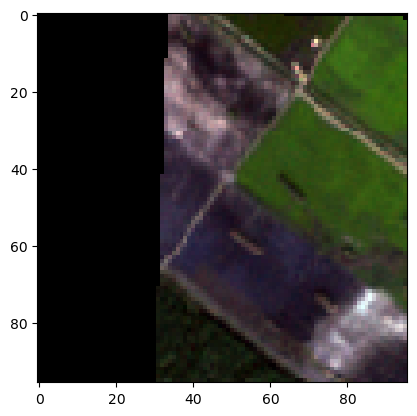

In [72]:

def normalize_img(img):
    #img = np.where(img >=0, img, 0)
    img_min, img_max = img.min(axis=0).min(axis=0), img.max(axis=0).max(axis=0)
    print(f'min={img_min},max={img_max},max-min={img_max-img_min}')
    return (img - img_min)/(img_max-img_min)

def normalize_img(img):
    #img = np.where(img >=0, img, 0)
    for ch in range(img.shape[-1]):
        channel = img[...,ch]
        mask = channel != 0
        min_ch = channel[mask].min()
        max_ch = channel[mask].max()
        img[...,ch] = (channel-min_ch)/(max_ch-min_ch)
        #print(f'min_ch={min_ch};max_ch={max_ch}')
    #img_min, img_max = img.min(axis=0).min(axis=0), img.max(axis=0).max(axis=0)
    #print('PIDR')
    #print(f'min={img_min},max={img_max}')
    return img#(img - img_min)/(img_max-img_min)

for idx, (imgs, gr_true) in enumerate(test_loader):
    gr_true = gr_true.cpu().numpy()
    imgs = imgs.cpu().numpy()
    break
for img, gt in zip(imgs, gr_true):
    if len(test_loader.dataset.specter_bands_list) == 4 or len(test_loader.dataset.specter_bands_list) == 10:
        img = img[0:3]
    elif len(test_loader.dataset.specter_bands_list) == 13:
        img = img[1:4]
    img = img.transpose(1, 2, 0)
    img = normalize_img2(img, gt)
    break

plt.imshow(img)

In [69]:
for ch in range(img.shape[-1]):
    channel = img[...,ch]
    mask = channel != 0
    min_ch = channel[mask].min()
    max_ch = channel[mask].max()
    #img[...,ch] = (channel-min_ch)/(max_ch-min_ch)
    print(f'min_ch={min_ch};max_ch={max_ch}')

min_ch=0.027466658502817154;max_ch=0.04907376319169998
min_ch=0.01977599412202835;max_ch=0.05166783556342125
min_ch=0.013794366270303726;max_ch=0.06735435128211975


In [68]:
channel[mask].min()

np.float32(0.0)

In [66]:
96**2

9216

In [65]:
mask.sum()

np.int64(5927)

In [23]:
mask = gr_true[0] != 0
mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:0')

In [19]:
mask = imgs[15] >= 0
mask.shape

torch.Size([4, 96, 96])

# HSI-UAV

In [2]:
def generate_grayscale_palette(size):
    max_val = 0xffffff
    step = max_val // size

    print(step)
    palette = []
    for i in range(0, max_val, step):
        palette.append(f'#{i:06x}')

    
    return palette

def draw_results(pix2color, pix2class, img, gt_mask, pred_mask, figsize, set_title, legend, transpose):
    vals_in_mask = np.unique(pred_mask)
    missing = [v for v in vals_in_mask if v not in pix2color]
    if missing:
        raise ValueError(f"Нет цветов для значений: {missing}")
    
    values = sorted(pix2color.keys())
    colors = [pix2color[v] for v in values]

    # Создаём дискретную cmap и norm
    cmap = ListedColormap(colors, name="pixmap", N=len(colors))
    boundaries = np.array(values, dtype=float)
    boundaries = np.concatenate((
        [boundaries[0] - 0.5],
        (boundaries[:-1] + boundaries[1:]) / 2,
        [boundaries[-1] + 0.5]
    ))
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Рисуем маску
    if transpose:
        figsize = figsize[::-1]
        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, dpi=120)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize, dpi=120)
    im = axs[0].imshow(img)
    if set_title:
        axs[0].set_title("Image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[1].set_title("Ground truth")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    im = axs[2].imshow(pred_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[2].set_title("Pred")
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    # Формируем список патчей для легенды
    patches = [
        mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
        for val in values if val in vals_in_mask
    ]
    if legend:
        # Добавляем легенду сбоку
        axs[2].legend(
            handles=patches,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            title="Classes"
        )

    plt.tight_layout()
    plt.show()

# Генерация палитры из 5 цветов
palette = generate_grayscale_palette(30)
palette = [
    '#FF0000',
    '#00FF00',
    '#0000FF',
    '#FFFF00',
    '#FF00FF',
    '#00FFFF',
    '#FF8000',
    '#8000FF',
    '#00FF80',
    '#FF0080',
    '#80FF00',
    '#0080FF',
    '#FF4040',
    '#40FF40',
    '#4040FF',
    '#FFFF40',
    '#FF40FF',
    '#40FFFF',
    '#FF8040',
    '#8040FF',
    '#40FF80',
    '#FF4080',
    '#80FF40',
    '#4080FF',
    '#FFC0C0',
    '#C0FFC0',
    '#C0C0FF',
    '#FFFFC0',
    '#FFC0FF',
    '#C0FFFF',
]
palette = {i: c for i, c in enumerate(palette)}
pix2class = {i:f'{i}' for i in palette.keys()}


559240


In [ ]:


path_to_model_config = r'C:\Users\mokhail\develop\MultispectralSegmentation\saving_dir\unet_tu-cspdarknet53_HSI 2025-10-25T22-28-00\training_config.yaml'
path_to_model_config = r'z:\mikhail_u\HSI_ref_results\unet_aux_att_tu-cspdarknet53_HSI_chatt_300ep 2025-11-04T03-57-38\training_config.yaml'
path_to_weights = glob.glob(os.path.join(os.path.split(path_to_model_config)[0], '*.ckpt'))[0]
with open(path_to_model_config) as fd:
    config_dict = yaml.load(fd, yaml.Loader)

model_state_dict = torch.load(path_to_weights)['state_dict']
# Необходимо удалить имя верхнего уровеня в state dict
model_state_dict = {'.'.join(k.split('.')[1:]): w for k, w in model_state_dict.items()}

model = create_model(config_dict, segmentation_nns_factory_dict)
model.load_state_dict(model_state_dict)
model = model.to(config_dict['device'])
model.eval()
print()

In [ ]:


img = np.random.randn(14, 88, 3)
img_min, img_max = img.min(axis=0).min(axis=0), img.max(axis=0).max(axis=0)
img = (img - img_min)/(img_max-img_min)
img.shape

(14, 88, 3)

In [ ]:
i

In [13]:
def normalize(band):
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)


def pseudo_rgb(img):
    # Выберите каналы для R, G, B. Номера зависят от длин волн.
    red_channel = 150    # Близко к 700 нм
    green_channel = 100  # Близко к 550 нм
    blue_channel = 50    # Близко к 450 нм

    # Извлечение каналов и нормализация значений
    red = img[red_channel].astype(float)
    green = img[green_channel].astype(float)
    blue = img[blue_channel].astype(float)
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)

    # Создание RGB изображения
    rgb_image = np.dstack((red_n, green_n, blue_n))
    return rgb_image

def pseudo_rgb2(cube, rgb_wls=(640,550,470), stretch_percentiles=(2,98)):
    #def visualize_hsi_cube(cube, wavelengths, rgb_wls=(640,550,470), stretch_percentiles=(2,98)):
    ##import numpy as np
    #import matplotlib.pyplot as plt

    B = cube.shape[2]
    wavelengths = np.linspace(400, 1000, B)

    H, W, B = cube.shape
    # найти индексы для RGB
    idx_r = np.argmin(np.abs(wavelengths - rgb_wls[0]))
    idx_g = np.argmin(np.abs(wavelengths - rgb_wls[1]))
    idx_b = np.argmin(np.abs(wavelengths - rgb_wls[2]))
    print("Using bands:", idx_r, idx_g, idx_b, wavelengths[idx_r], wavelengths[idx_g], wavelengths[idx_b])

    rgb = np.stack([cube[idx_r], cube[idx_g], cube[idx_b]], axis=2)
    print(cube[:,:,idx_r].shape)
    p_low, p_high = stretch_percentiles
    rgb_norm = (rgb - np.percentile(rgb, p_low)) / (np.percentile(rgb, p_high) - np.percentile(rgb, p_low))
    rgb_norm = np.clip(rgb_norm, 0, 1)

    return rgb_norm

In [ ]:
path_to_dataset_root= r'C:\Users\admin\python_programming\DATA\UAV-HSI-Crop-Dataset'

test_dataset = HSI_dataset(
        path_to_dataset_partition=os.path.join(path_to_dataset_root, 'Test'),
        augmentation_transforms=nn.Identity(),
        device=torch.device('cuda')
        )

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
print('PIDR')

for imgs, gr_true in tqdm(dataloader):
    with torch.no_grad():
        pred = model(imgs)
    pred = pred.argmax(dim=1).squeeze(0).cpu().numpy()
    gr_true = gr_true.squeeze(0).cpu().numpy()
    imgs = imgs.squeeze(0).cpu().numpy()
    rgb = pseudo_rgb(imgs)
    rgb = pseudo_rgb2(imgs)
    draw_results(
        pix2color=palette,
        pix2class=pix2class,
        img=rgb, gt_mask=gr_true, pred_mask=pred,
        figsize=(4,1.6),
        set_title=False,
        legend=False,
        transpose=False)


In [ ]:
draw_results(
    pix2color=palette,
    pix2class=pix2class,
    img=rgb, gt_mask=gr_true, pred_mask=pred,
    figsize=(5,2),
    set_title=False,
    legend=False,
    transpose=True)